# VSB Powerline - augmented

basic L/R flip augmention for all (not just +ve)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [5]:
import fastai
print(fastai.__version__)

1.0.40.dev0


In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [9]:
DATE

'20190112'

In [10]:
UID

'edde7f91'

In [11]:
MODEL_NAME='600_aug_mathews_loss'

In [12]:
image_size=600
bs = 4  #16 too large

In [13]:
path = Path('../input/')
train_path = path/'train_600_aug/'

In [14]:
test_path = path/'test_600/'

In [15]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [16]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [17]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [18]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [19]:
aug_df['signal_id'] = aug_df['signal_id'].astype(str)+'_flip_lr'

#### remember to copy non aug images into folder

In [20]:
train_df = pd.concat([train_df, aug_df], ignore_index=True)

In [21]:
train_df.tail()

,signal_id,id_measurement,phase,target
17419,8707_flip_lr,2902,1,0
17420,8708_flip_lr,2902,2,0
17421,8709_flip_lr,2903,0,0
17422,8710_flip_lr,2903,1,0
17423,8711_flip_lr,2903,2,0


In [22]:
#lets drop augmented good images - CUDA oom errors

In [23]:
drop_df = train_df[(train_df['target'] == 0) & train_df['signal_id'].str.endswith('_flip_lr')]

In [24]:
idx_to_drop=list(drop_df.index.values)

In [25]:
len(idx_to_drop)

8187

In [26]:
train_df=train_df.drop(train_df.index[idx_to_drop])

In [27]:
train_df.tail()

,signal_id,id_measurement,phase,target
17195,8483_flip_lr,2827,2,1
17280,8568_flip_lr,2856,0,1
17281,8569_flip_lr,2856,1,1
17282,8570_flip_lr,2856,2,1
17342,8630_flip_lr,2876,2,1


### Image Data

In [28]:
tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [29]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

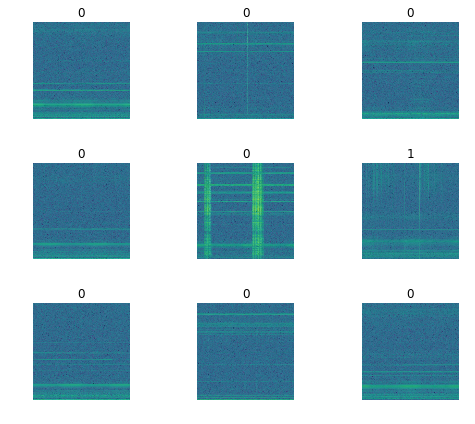

In [30]:
data.show_batch(rows=3, figsize=(7,6))

In [31]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

In [56]:
def matthews_corr_coeff(y_true, y_pred):
    print(f'y_true[0].shape: {y_true[0].shape}, y_pred[0].shape: {y_pred[0].shape}')
    print(y_true[0][0])
    print(y_true[0][1])
    print(y_pred[0])
    #y_true: torch.Size([64, 2]), y_pred: torch.Size([64])
    print(f'y_true: {y_true.shape}, y_pred: {y_pred.shape}')
    #RuntimeError: _th_round_out is not implemented for type torch.cuda.LongTensor
    #y_pos_pred = (torch.clamp(y_pred, 0, 1)).round()
    y_pos_pred = np.round(torch.clamp(y_pred, 0, 1))
    y_pos_true = np.round(torch.clamp(y_true, 0, 1))
    #y_pos_pred: torch.Size([64]), y_pos_true: torch.Size([64, 2])

    
    y_neg_pred = 1 - y_pos_pred
    y_neg_true = 1 - y_pos_true

    tp = torch.sum(y_pos_true * y_pos_pred)
    tn = torch.sum(y_neg_true * y_neg_pred)
    fp = torch.sum(y_neg_true * y_pos_pred)
    fn = torch.sum(y_pos_true * y_neg_pred)
    #keras _EPSILON = 1e-7
    return (tp * tn - fp * fn) / (torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-7)

In [57]:
metrics = [matthews_corr_coeff]
#metrics=error_rate

In [58]:
learn = create_cnn(data, models.resnet34, metrics=metrics)

### use 2x GPU's

This fails using 1x GPU and a bs of 2 - try with larger bs

In [59]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


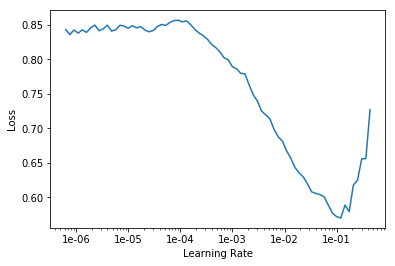

In [37]:
learn.recorder.plot()

#### fit

In [60]:
learn.fit_one_cycle(5, 9e-3)

epoch,train_loss,valid_loss,matthews_corr_coeff


y_true[0].shape: torch.Size([2]), y_pred[0].shape: torch.Size([])
tensor(4.6931, device='cuda:0')
tensor(-2.7331, device='cuda:0')
tensor(0, device='cuda:0')
y_true: torch.Size([64, 2]), y_pred: torch.Size([64])


RuntimeError: The size of tensor a (2) must match the size of tensor b (64) at non-singleton dimension 1

In [ ]:
learn.save(f'{MODEL_NAME}_stage-1')

In [ ]:
learn.fit_one_cycle(5, 9e-3)

## Results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

### Predict

In [ ]:
learn.load(f'{MODEL_NAME}_stage-1')

In [ ]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [ ]:
len(test_images), test_path

In [ ]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    if i==0:
        print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [ ]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [ ]:
df_sub=df_sub.reset_index()
df_sub.head()

In [ ]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [ ]:
df_sub.to_csv(path/f'submissions/submission_{MODEL_NAME}_aug_stage-1_{DATE}_{UID}.csv', index=False)
#submission 5 0.550
#submission_600_aug_stage-1_20181231_9e22e11c.csv

## Unfreezing, fine-tuning, and learning rates

sequence used when restarting NB here

restart NB

learn = create_cnn()

lean.model = dataparallel

learn.load

learn.unfreeze

learn.find

In [ ]:
learn.load(f'{MODEL_NAME}_stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
#learn.fit_one_cycle(5, max_lr=slice(1e-6,2e-5))
#5, max_lr=5e-6 final val_loss:0.057145
#5, max_lr=4e-6 final val_loss:0.059421, best after 1 epoch 0.055140
learn.fit_one_cycle(1, max_lr=4e-6)

In [ ]:
learn.save(f'{MODEL_NAME}_stage-2_unfeeze')

### 1x1 prediction

In [ ]:
#test_images = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [ ]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [ ]:
len(test_images)

In [ ]:
assert 20337 == len(test_images)

In [ ]:
img = open_image(test_images[0])
type(img)

In [ ]:
cat, val, probs=learn.predict(img)

In [ ]:
cat.__str__()

In [ ]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [ ]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [ ]:
df_sub=df_sub.reset_index()
df_sub.head()

In [ ]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [ ]:
df_sub.head()

In [ ]:
df_sub.target.nunique()

In [ ]:
len(df_sub)

In [ ]:
df_sub.to_csv(path/f'submissions/submission_{MODEL_NAME}_stage-2_unfeeze_{DATE}_{UID}.csv', index=False)
#submission 6 - TODO
#

In [ ]:
print('saved')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg', bs=4)
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                   size=image_size, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=metrics)

In [ ]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [ ]:
learn.lr_find()


In [ ]:
learn.recorder.plot()

In [ ]:
max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(8, lrs)

In [ ]:
#learn.fit_one_cycle(8)

In [ ]:
learn.save(f'{MODEL_NAME}_stage-1-50')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

In [ ]:
learn.save(f'{MODEL_NAME}_stage-2-50')

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

In [ ]:
learn.save(f'{MODEL_NAME}_stage-2-2-50')

In [ ]:
#learn.load('baseline_stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
### Predict

In [ ]:
learn.load(f'{MODEL_NAME}_stage-2-50')

In [ ]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [ ]:
df_sub_50_u=pd.DataFrame.from_dict(d, orient='index')

In [ ]:
df_sub_50_u=df_sub_50_u.reset_index()


In [ ]:
df_sub_50_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_50_u.head()

In [ ]:
df_sub_50_u.to_csv(path/f'submissions/submission_{MODEL_NAME}_resnet-50_unfeeze-2-2_{DATE}_{UID}.csv', index=False)

In [ ]:
#submission 3 0.478
#submission_aug_resnet-50_unfeeze-2-2_20181229_d1a603dc.csv
